# What is about?

This notebook describes the calculations that were carried out in the article [Nigmatullin, R., A. Ivchenko and Semyon Dorokhin. **“Differentiation of Sliding Rescaled Ranges: New Approach to Encrypted and VPN Traffic Detection.”** (2020)](
https://arxiv.org/abs/2012.08356)

This notebook describes the calculations that were carried out in the article

We propose a new data preprocessing method that develops Hirst's ideas. In this notebook, we work with flow-beyst signs, but you can check that the approach works well for packet-beyst signs.

A well-known [ISCX-network-traffic-VPN-dataset](https://www.researchgate.net/publication/291697471_Characterization_of_Encrypted_and_VPN_Traffic_Using_Time-Related_Features) was analyzed to confirm the effectiveness of the approach.


In [11]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.pylabtools import figsize

from scipy.io import arff
import pandas as pd

import math

from sklearn import preprocessing
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import progressbar

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

# 15 s

In [12]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-15s-VPN.arff')
df = pd.DataFrame(data[0])

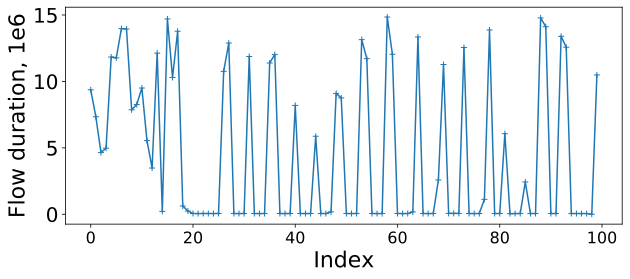

In [13]:
f, ax = plt.subplots(figsize=(10, 4))

x = np.arange(0, 100, 1).tolist()
y = df["duration"][0:100]/1000000
ax.plot(x, y, '+', linestyle='solid')

plt.xlabel('Index', size = 22);
plt.ylabel('Flow duration, 1e6', size = 22);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=20)

plt.show()

In [14]:
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,b'Non-VPN'
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,b'Non-VPN'
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,b'Non-VPN'
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,b'Non-VPN'
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,b'Non-VPN'


In [15]:
X = df.drop('class1', axis=1)

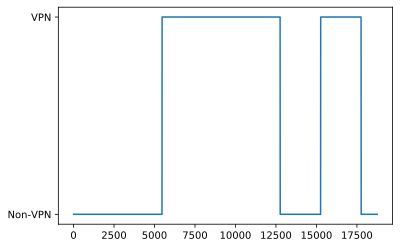

In [16]:
import matplotlib.pyplot as plt

y = df["class1"]
plt.plot(y)

In [17]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1    

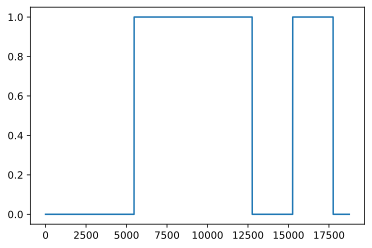

In [18]:
plt.plot(y_bin)

In [19]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

## Random Forest

In [20]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8939232409381663


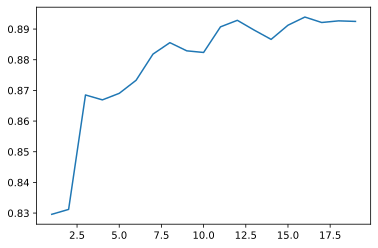

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

## Hurst test

In [22]:
def FirstDerivative(y):
  L = len(y)
  der = np.zeros(L)
  der[0] = 0
  for i in range(1, L):
    der[i] = y[i] - y[i-1]
  return der

In [23]:
def CalculateHurst(y, a, N_steps):
  hurst = np.zeros(N_steps)
  #progress = progressbar.ProgressBar()
  #for i in progress(range(0, N_steps)):
  for i in range(0, N_steps):
    mx = max(y[0:a*(i+1)])
    mn = min(y[0:a*(i+1)])
    devi = np.std(y[0:a*(i+1)])
    hurst[i] = (mx-mn) / (devi + 1e-18)
    if(math.isnan(hurst[i])):
      print("Error!")
  return hurst

In [24]:
import progressbar

def GenerateNewFeatures(X, start_offset, w_size, a):
  N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
  L = N_steps * w_size
  N_features = X.shape[1]
  X_new = np.zeros((L, N_features))
  N_steps_window = int(np.floor(w_size / a))
  progress = progressbar.ProgressBar()
  for i in progress(range(0, N_features)):
    for j in range(0, N_steps):
      hurst = CalculateHurst(X[start_offset+j*w_size:start_offset+(j+1)*w_size, i], a, N_steps_window)
      #print(len(X.iloc[i*w_size:(i+1)*w_size, j]))
      #i_hurst = integral(hurst - np.mean(hurst))
      X_new[j*w_size:(j+1)*w_size, i] = FirstDerivative(hurst)
  return X_new

In [25]:
plt.savefig("Hurst/plot.png")

<Figure size 432x288 with 0 Axes>

In [26]:
def GeneratePlots(X, start_offset, w_size, a, feature_number, y):
  # Generate plots of rescaled ranges, derivative and label for a chosen feature
  # y = 1 -- VPN, y = 0 -- non-VPN
  N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
  L = N_steps * w_size
  N_features = X.shape[1]
  X_new = np.zeros((L, N_features))
  N_steps_window = int(np.floor(w_size / a))
  progress = progressbar.ProgressBar()
  for j in range(0, N_steps):
    if (j == 35):
      hurst = CalculateHurst(X[start_offset+j*w_size:start_offset+(j+1)*w_size, i], a, N_steps_window)
      #print(len(X.iloc[i*w_size:(i+1)*w_size, j]))
      #i_hurst = integral(hurst - np.mean(hurst))
      X_new[j*w_size:(j+1)*w_size, i] = FirstDerivative(hurst / max(hurst))
      plt.figure(j, figsize=(30, 10))
      print(j)
      plt.plot(hurst / max(hurst), "b--", linewidth=5.0, markersize=25, label='rescaled ranges')
      plt.plot(X_new[j*w_size:(j+1)*w_size, i], "r--", linewidth=5.0, markersize=25, label="derivative")
      plt.plot(y[j*w_size:(j+1)*w_size], "g--", linewidth=5.0, markersize=25, label="label, 1 - VPN, 0 - nonVPN")

      plt.legend(fontsize=25, ncol=1, loc='upper right', bbox_to_anchor=(1, 0.86))
      plt.grid(b=True, which='major', color='k', linestyle='-')
      plt.grid(b=True, which='minor', linestyle='--')
      plt.xlabel('Time index', fontsize = 50)
      plt.ylabel('Amplitude', fontsize = 50)
      plt.xticks(fontsize=45, rotation=0)
      plt.yticks(fontsize=45, rotation=0)

      sub_axes = plt.axes([.315, .62, .2, .2]) 
      sub_axes.plot(np.linspace(160, 249, 90), X_new[j*w_size+160:j*w_size + 250, i], c = 'r') 
      plt.xticks(fontsize=35, rotation=0)
      plt.yticks(fontsize=35, rotation=0)
      plt.grid(b=True, which='major', color='k', linestyle='-')
      plt.grid(b=True, which='minor', linestyle='--')

      sub_axes2 = plt.axes([.585, .32, .3, .2]) 
      sub_axes2.plot(np.linspace(280, 499, 220), X_new[j*w_size+280:j*w_size + 500, i], c = 'r')
      plt.xticks(fontsize=35, rotation=0)
      plt.yticks(fontsize=35, rotation=0)
      plt.grid(b=True, which='major', color='k', linestyle='-')
      plt.grid(b=True, which='minor', linestyle='--')

      plt.savefig("Hurst/plot.png")
      plt.show() 
      plt.figure(1)
      plt.plot(X_new[j*w_size+150:j*w_size + 250, i])

      plt.figure(2)
      plt.plot(X_new[j*w_size+280:j*w_size + 500, i])

In [27]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


35


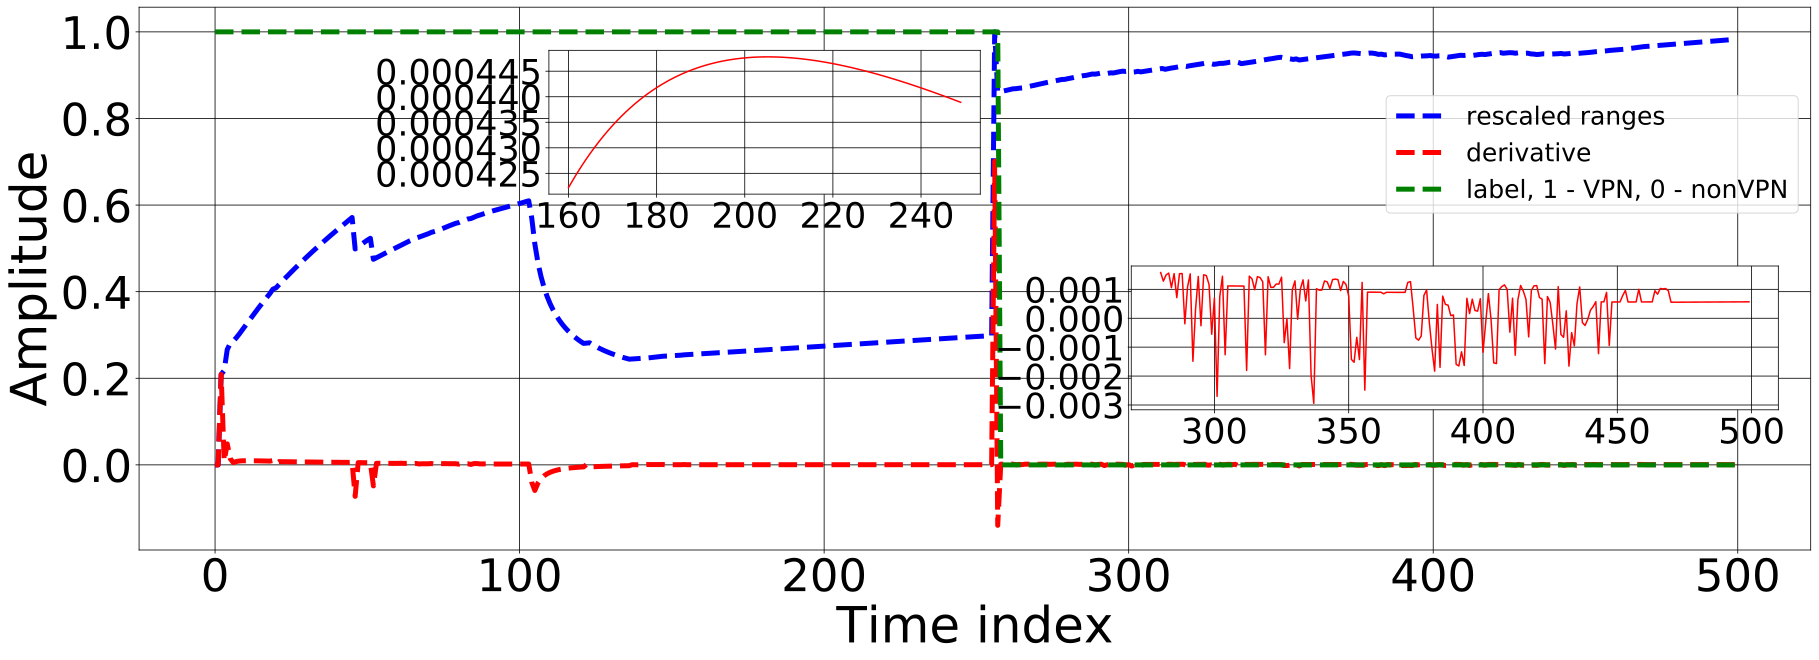

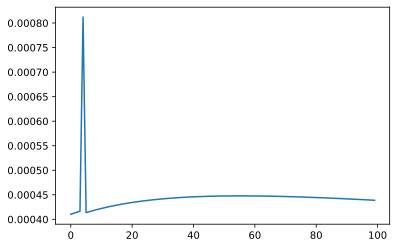

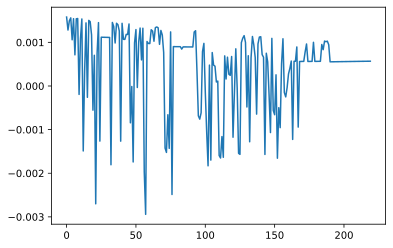

In [28]:
GeneratePlots(X, start_offset, w_size, a, 0, y_bin)

35


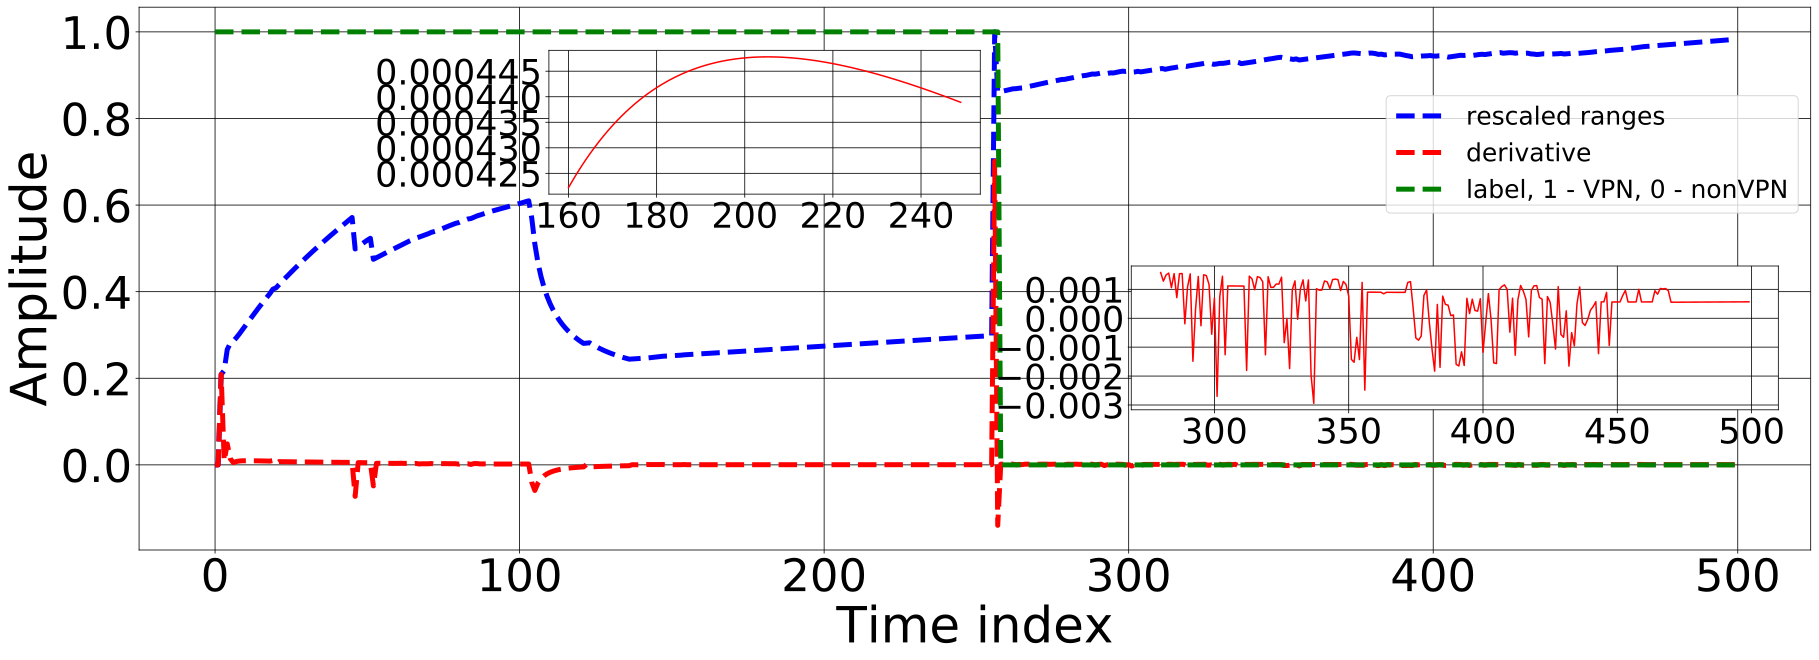

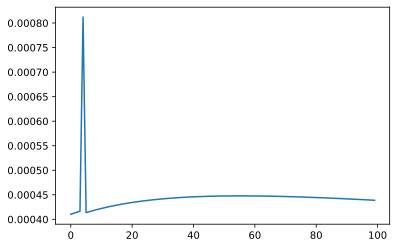

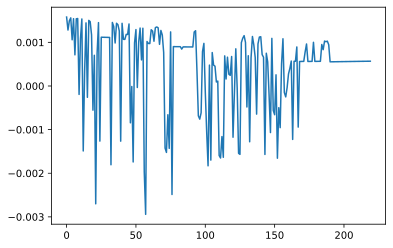

In [29]:
GeneratePlots(X, start_offset, w_size, a, 7, y_bin)

In [30]:
from sklearn.model_selection import train_test_split

N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [23]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=60)
dtc_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    dtc.n_estimators = i
    dtc.fit(X_train, y_train.ravel())
    dtc_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))


100% |########################################################################|


In [31]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-30s-VPN.arff')
df = pd.DataFrame(data[0])

X = df.drop('class1', axis=1)
y = df["class1"]

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1 

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)


N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

100% |########################################################################|


In [32]:
RF = RandomForestClassifier()
RF_pr = []
RF_rc = []
RF_f1 = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

print ("Pr",max(RF_pr)   ) 
print ("Rc",max(RF_rc))
print ("F1",max(RF_f1))

Pr 0.9629637112553127
Rc 0.9622229064039409
F1 0.9625635574852061


In [33]:
def open_and_preprocessed (data):

    data = arff.loadarff(data)
    df = pd.DataFrame(data[0])
    
    X = df.drop('class1', axis=1)
    y = df["class1"]

    lb = preprocessing.LabelBinarizer()
    y_bin = np.zeros(len(y))

    for i in range(0, len(y)):
      if y[i] == b'Non-VPN':
        y_bin[i] = 0
      if y[i] == b'VPN':
        y_bin[i] = 1 

    scaler = MinMaxScaler()
    X = np.nan_to_num(X)
    scaler.fit(X)
    X = scaler.transform(X)

    w_size = 500
    a = 1
    start_offset = 0
    X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

    N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])
    
    return X_train_full, X_test_full, y_train_full, y_test_full

In [34]:
X_tr15, X_t15, y_tr15, y_t15 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-15s-VPN.arff')

100% |########################################################################|


In [35]:
def model_quality(X_train_full, X_test_full, y_train_full, y_test_full, model):
    RF = model
    RF_pr = []
    RF_rc = []
    RF_f1 = []

    progress = progressbar.ProgressBar()
    for i in progress(range(1, 20)):
        RF.n_estimators = i
        RF.fit(X_train_full, y_train_full.ravel())
        RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
        RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
        RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

    print ("Pr",max(RF_pr)) 
    print ("Rc",max(RF_rc))
    print ("F1",max(RF_f1))

In [36]:
model_quality(X_tr15, X_t15, y_tr15, y_t15, RandomForestClassifier())

Pr 0.9598723070353034
Rc 0.959138817855903
F1 0.959469107909588


In [37]:
X_tr30, X_t30, y_tr30, y_t30 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-30s-VPN.arff')

100% |########################################################################|


In [38]:
model_quality(X_tr30, X_t30, y_tr30, y_t30, RandomForestClassifier())

Pr 0.9653371763602889
Rc 0.9653940886699508
F1 0.965365425809398


In [39]:
X_tr60, X_t60, y_tr60, y_t60 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')

100% |########################################################################|


In [40]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, RandomForestClassifier())

Pr 0.9668006955315643
Rc 0.9656095325012359
F1 0.9660267608338291


In [41]:
X_tr120, X_t120, y_tr120, y_t120 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-120s-VPN.arff')

100% |########################################################################|


In [42]:
model_quality(X_tr120, X_t120, y_tr120, y_t120, RandomForestClassifier())

Pr 0.9616950164564704
Rc 0.962508343028875
F1 0.9620583763535775


## Various ML-models
Ath this section we are trying to understand the gain of applying our approach

In [43]:
X_tr60, X_t60, y_tr60, y_t60 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')

100% |########################################################################|


In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [45]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, DecisionTreeClassifier(random_state=60))

Pr 0.935940295520596
Rc 0.9368124062281791
F1 0.9363527750624525


In [46]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, LogisticRegression(random_state=60))

Pr 0.4499018050948591
Rc 0.49900272891079817
F1 0.35872168103530266


In [47]:
from sklearn.metrics import precision_score, recall_score,f1_score

RF = RandomForestClassifier()
RF_pr = []
RF_rc = []
RF_f1 = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

print ("Pr",max(RF_pr)   ) 
print ("Rc",max(RF_rc))
print ("F1",max(RF_f1))

Pr 0.9639778325123153
Rc 0.9639778325123153
F1 0.9639778325123153


In [48]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, SVC(kernel='linear', C=1.0, random_state=1))

/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classi

Pr 0.27623655913978495
Rc 0.5
F1 0.3558664634990996


In [49]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0))

Pr 0.5388430010637633
Rc 0.5027867100603824
F1 0.3747732205194767


In [50]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

Pr 0.9186761229314421
Rc 0.919884985079747
F1 0.9192300623672045


# PhiK correlation coefficient
This section explores which features are most strongly associated with the target variable (traffic class).

Also, if we find pairwise correlations, their removal of one of the features can improve the generalizing ability of the model.

You can learn a bit more about univercal correlation coefficient PhiK [librarty here](https://phik.readthedocs.io/en/latest/phik.html) and read the original paper [A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics](https://arxiv.org/abs/1811.11440)

In [126]:
import phik
from phik import resources, report

# open fake car insurance data
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')
df = pd.DataFrame(data[0])

# Pearson's correlation matrix between numeric variables (pandas functionality)
df.corr()

# get the phi_k correlation matrix between all variables
df.phik_matrix()

# get global correlations based on phi_k correlation matrix
df.global_phik()

# get the significance matrix (expressed as one-sided Z)
# of the hypothesis test of each variable-pair dependency
df.significance_matrix()

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']
interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


/home/ksant/.local/lib/python3.7/site-packages/phik/phik.py:248: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.array([[np.sqrt(1 - 1/(V[i][i] * Vinv[i][i]))] for i in range(V.shape[0])])


interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
duration,67.108137,13.795754,10.779477,50.548813,23.572276,34.425468,14.833719,43.137039,18.075252,-0.693623,...,48.926252,54.575041,55.903196,57.954851,12.930362,53.995092,55.188169,57.486073,13.142640,10.552485
total_fiat,13.795754,136.929709,100.496965,2.747997,1.609987,92.792780,94.547623,5.109678,24.934197,-0.018389,...,47.782837,3.355970,3.649435,3.942898,13.984637,3.221882,3.504674,3.884921,14.140110,25.678801
total_biat,10.779477,100.496965,124.836728,2.168665,1.167673,64.453366,110.917006,12.530951,13.992740,-0.004553,...,52.804719,2.606694,2.928522,3.228857,6.647559,2.558456,2.785734,3.148373,6.492672,24.037193
min_fiat,50.548813,2.747997,2.168665,54.965809,-0.879724,33.587860,2.206486,46.347706,0.279043,-0.823300,...,41.965913,48.023844,49.644881,52.219412,11.657608,48.221628,49.568940,52.386492,11.738294,14.583482
min_biat,23.572276,1.609987,1.167673,-0.879724,37.875798,2.041929,16.950415,-0.326959,27.755340,-0.323584,...,17.621175,22.671878,22.797246,23.731944,8.203045,22.355886,22.532018,23.443944,8.335459,7.267103
max_fiat,34.425468,92.792780,64.453366,33.587860,2.041929,113.406724,71.828988,41.101231,23.999958,0.509778,...,63.563489,32.795344,32.859696,32.723335,11.406522,32.803512,32.874170,32.750953,11.821571,23.672593
max_biat,14.833719,94.547623,110.917006,2.206486,16.950415,71.828988,149.618020,24.768263,58.380123,0.609967,...,59.653201,10.700800,10.238764,10.096362,22.872586,10.878157,10.330658,10.195567,23.752299,27.778610
mean_fiat,43.137039,5.109678,12.530951,46.347706,-0.326959,41.101231,24.768263,67.438210,24.404383,-0.576713,...,54.843674,42.735424,43.730643,44.316438,8.664529,42.842372,43.790608,44.404050,8.825549,10.791797
mean_biat,18.075252,24.934197,13.992740,0.279043,27.755340,23.999958,58.380123,24.404383,113.622253,0.516637,...,33.091774,19.164051,18.920517,18.904054,35.911654,19.452139,19.028544,18.955328,36.952015,10.153416
flowPktsPerSecond,-0.693623,-0.018389,-0.004553,-0.823300,-0.323584,0.509778,0.609967,-0.576713,0.516637,24.046568,...,0.255126,-0.820104,-0.731590,-0.673184,-0.000539,-0.792933,-0.644724,-0.677160,-0.011508,1.703268


interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']
interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


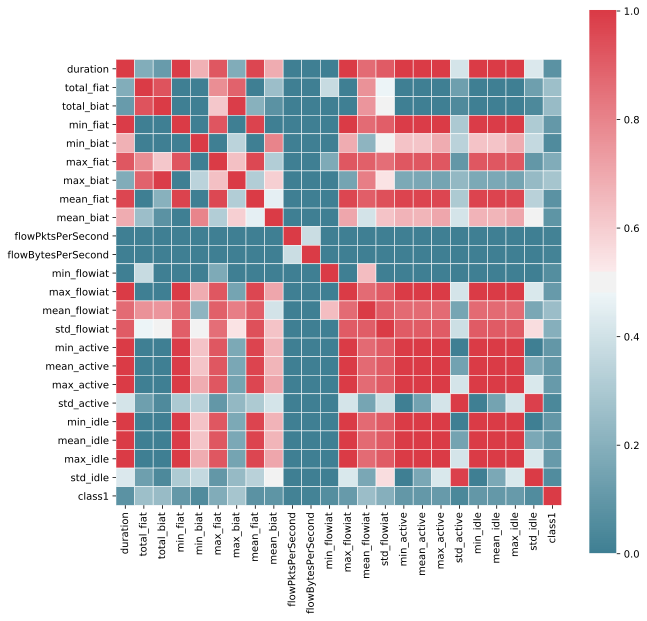

In [53]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.phik_matrix(), mask=np.zeros_like(df.phik_matrix(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, linewidths=.5)

In [54]:
global_correlation, global_labels = df.global_phik()
for c, l in zip(global_correlation, global_labels):
    print(l, c[0])

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']
duration 0.9983434086182311
total_fiat 0.09535639520588743
total_biat 0.8071701695812192
min_fiat nan
min_biat nan
max_fiat 0.9567633128156798
max_biat 1.3360760730475851
mean_fiat 0.9012866813976647
mean_biat nan
flowPktsPerSecond 0.380770770786498
flowBytesPerSecond 0.38087549887539657
min_flowiat nan
max_flowiat 1.0
mean_flowiat 0.9165697988554041
std_flowiat 0.9902382912710678
min_active 1.0000640697545156
mean_active 1.000056495895636
max_active 0.9995420095852783
std_active 1.2628321637208175
min_idle 1.0000618975481586
mean_idle 1.0000720571857642
max_idle 1.0
std_idle 1.3310518596566037
class1 0.7479938568119513


In [56]:
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

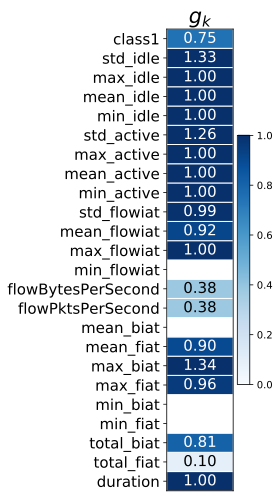

In [57]:
plot_correlation_matrix(global_correlation, x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,7),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=1.5)
plt.tight_layout()

This shows how well each variable defines the others in the dataset


In [58]:
df.phik_matrix()

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
duration,1.000000,0.185614,0.113856,0.993256,0.676473,0.920075,0.180673,0.966102,0.689810,0.000000,...,0.909105,0.998111,0.997938,0.999170,0.407430,0.997915,0.997746,0.999054,0.427412,0.080497
total_fiat,0.185614,1.000000,0.931368,0.000000,0.000000,0.773145,0.890169,0.000000,0.257350,0.000000,...,0.473723,0.000000,0.000000,0.000000,0.131518,0.000000,0.000000,0.000000,0.132001,0.257831
total_biat,0.113856,0.931368,1.000000,0.000000,0.000000,0.614586,0.991664,0.199232,0.080901,0.000000,...,0.510457,0.000000,0.000000,0.000000,0.045974,0.000000,0.000000,0.000000,0.042135,0.242330
min_fiat,0.993256,0.000000,0.000000,1.000000,0.000000,0.925170,0.000000,0.975807,0.000000,0.000000,...,0.899557,0.995330,0.995492,0.996629,0.297709,0.995676,0.995738,0.996926,0.306224,0.104445
min_biat,0.676473,0.000000,0.000000,0.000000,1.000000,0.000000,0.340557,0.000000,0.796956,0.000000,...,0.486117,0.628578,0.622906,0.689037,0.336671,0.627690,0.622706,0.688125,0.366893,0.047071
max_fiat,0.920075,0.773145,0.614586,0.925170,0.000000,1.000000,0.635203,0.957794,0.320095,0.000000,...,0.857947,0.921409,0.921278,0.920218,0.097727,0.921605,0.921443,0.920397,0.100961,0.183028
max_biat,0.180673,0.890169,0.991664,0.000000,0.340557,0.635203,1.000000,0.320193,0.593829,0.000000,...,0.542612,0.168300,0.163152,0.150517,0.232329,0.169991,0.165088,0.151756,0.241004,0.281618
mean_fiat,0.966102,0.000000,0.199232,0.975807,0.000000,0.957794,0.320193,1.000000,0.456758,0.000000,...,0.940072,0.968832,0.969923,0.968064,0.302303,0.969034,0.970134,0.968258,0.333970,0.081398
mean_biat,0.689810,0.257350,0.080901,0.000000,0.796956,0.320095,0.593829,0.456758,1.000000,0.000000,...,0.625919,0.669302,0.664882,0.705123,0.407603,0.671789,0.667518,0.706705,0.511340,0.089076
flowPktsPerSecond,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014848


interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


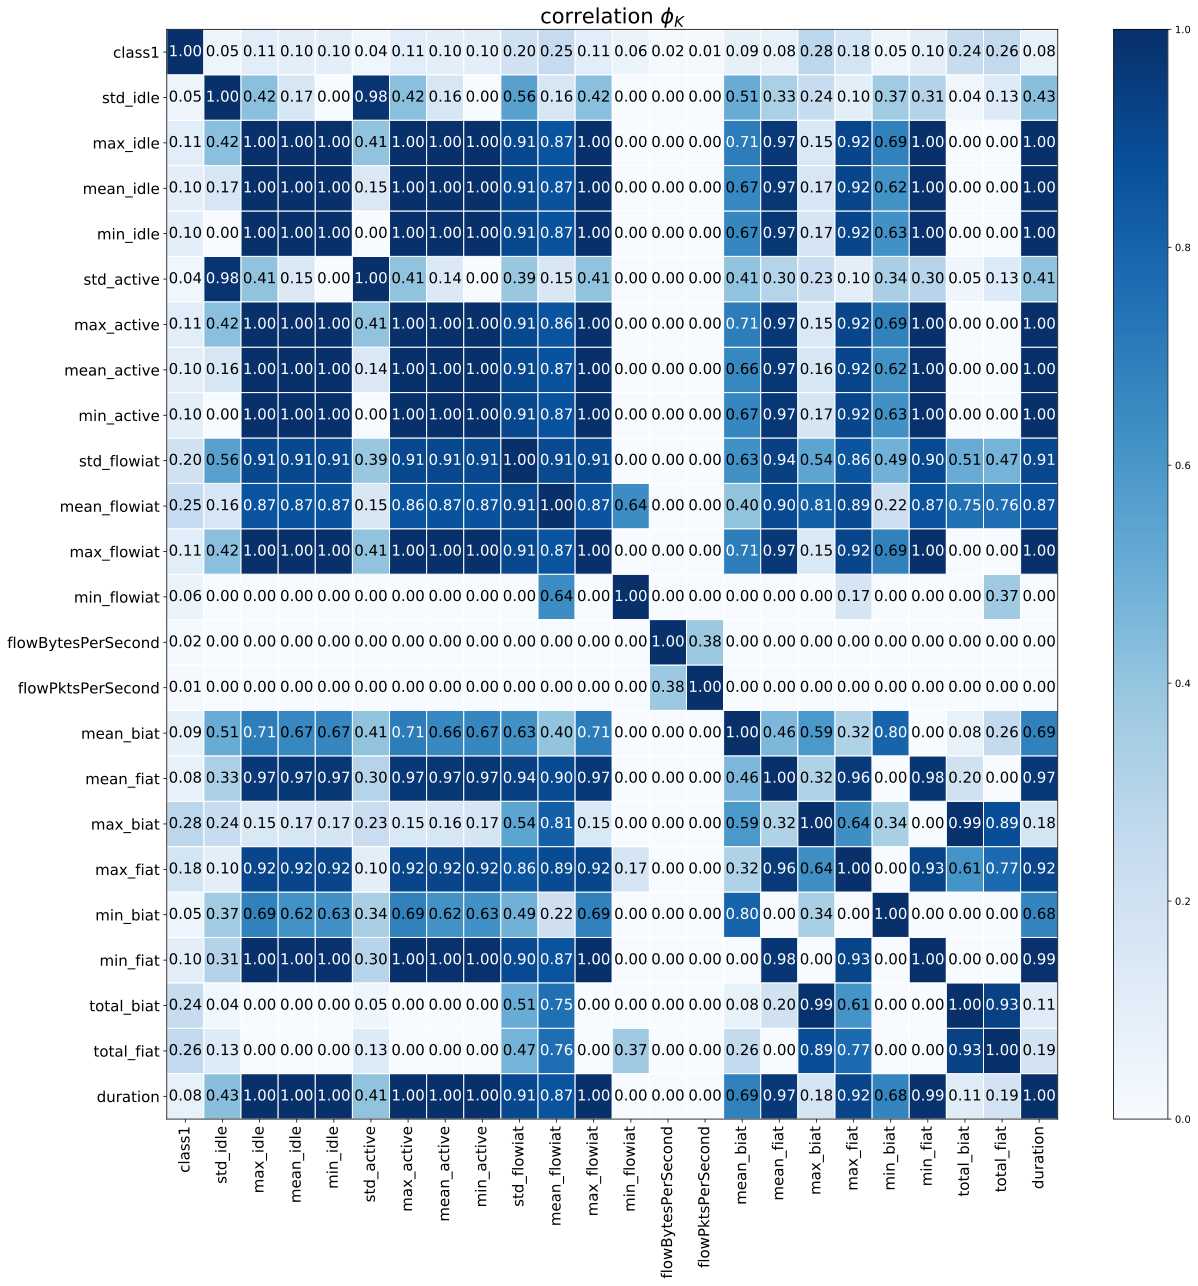

In [59]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(18,18))
plt.tight_layout()

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']
interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


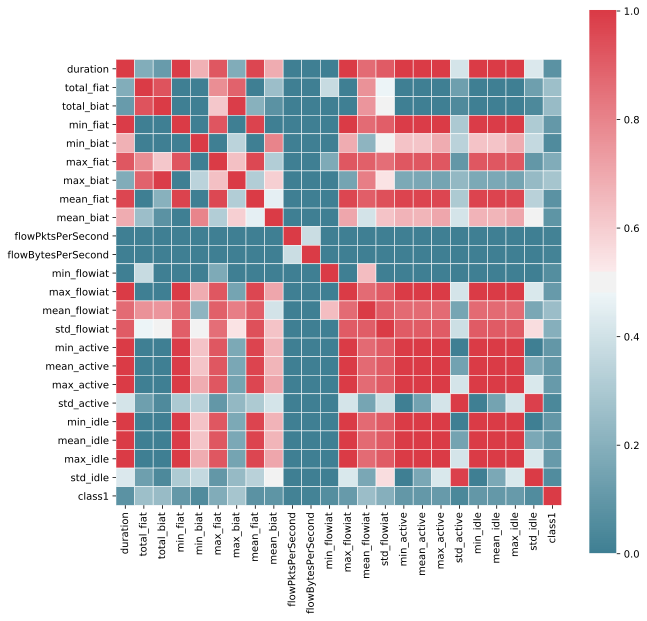

In [60]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.phik_matrix(), mask=np.zeros_like(df.phik_matrix(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, linewidths=.5)

In [61]:
small_df = df [["max_biat","total_fiat","total_biat","min_fiat", "class1"]]

In [62]:
phik_overview = small_df.phik_matrix()

interval columns not set, guessing: ['max_biat', 'total_fiat', 'total_biat', 'min_fiat']


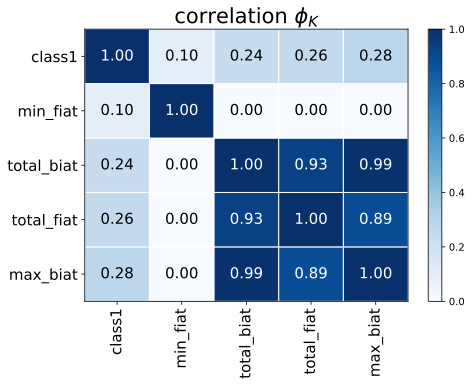

In [63]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(7,5.5))
plt.tight_layout()

In [64]:
significance_overview = small_df.significance_matrix()

interval columns not set, guessing: ['max_biat', 'total_fiat', 'total_biat', 'min_fiat']


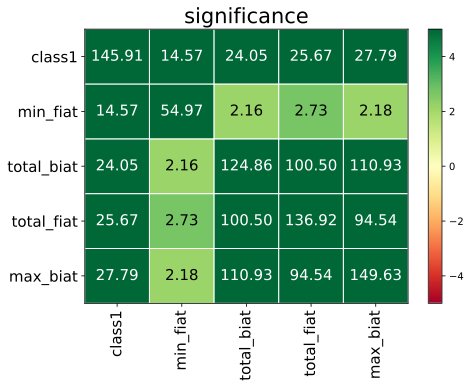

In [65]:
plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(7,5.5))
plt.tight_layout()

In [66]:
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15515 entries, 0 to 15514
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   max_biat    15515 non-null  float64
 1   total_fiat  15515 non-null  float64
 2   total_biat  15515 non-null  float64
 3   min_fiat    15515 non-null  float64
 4   class1      15515 non-null  object 
dtypes: float64(4), object(1)
memory usage: 606.2+ KB


In [67]:
small_df.shape

(15515, 5)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = small_df.drop('class1', axis=1)
y = small_df["class1"]

from sklearn import preprocessing
import numpy as np

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

In [69]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))



100% |########################################################################|


0.825563909774436


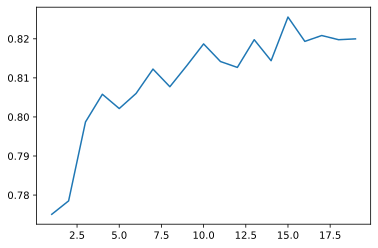

In [70]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

In [130]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=60)
dtc_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    dtc.n_estimators = i
    dtc.fit(X_train, y_train.ravel())
    dtc_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.5125193199381762


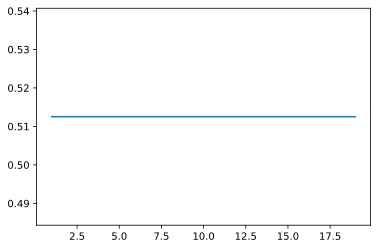

In [131]:
plt.plot(range(1, 20), dtc_acc, label="Accuracy")
print(max(dtc_acc))

In [73]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')
df = pd.DataFrame(data[0])

In [74]:
from itertools import combinations_with_replacement, combinations
feature_combs_2 = list(combinations(df.columns, 2))

In [75]:
corr_list=[]
for l in range(len(feature_combs_2)):
    sp = kendalltau (df[feature_combs_2[l][0]],df[feature_combs_2[l][1]])
    corr_list.append ([sp[0], sp[1],feature_combs_2[l]])
    
corr_list.sort(key=lambda x: x[0])
corr_list[-28:-1]

[[0.7690802278227392, 0.0, ('min_fiat', 'std_flowiat')],
 [0.7761736359320018, 0.0, ('min_fiat', 'max_idle')],
 [0.7861278038336029, 0.0, ('std_flowiat', 'mean_idle')],
 [0.7876988620902511, 0.0, ('min_fiat', 'max_fiat')],
 [0.7881048996625362, 0.0, ('max_flowiat', 'std_flowiat')],
 [0.8039723317425864, 0.0, ('max_flowiat', 'mean_active')],
 [0.8073829437832974, 0.0, ('min_biat', 'max_biat')],
 [0.810847344425565, 0.0, ('min_fiat', 'max_flowiat')],
 [0.8201737053915075, 0.0, ('max_flowiat', 'mean_idle')],
 [0.8326691554746279, 0.0, ('max_flowiat', 'max_active')],
 [0.841955238114581, 0.0, ('max_active', 'min_idle')],
 [0.8556252033122219, 0.0, ('min_active', 'max_idle')],
 [0.8585633594358677, 0.0, ('flowPktsPerSecond', 'flowBytesPerSecond')],
 [0.8601207409216909, 0.0, ('min_active', 'max_active')],
 [0.8673656451834595, 0.0, ('min_idle', 'max_idle')],
 [0.8713201530816265, 0.0, ('max_flowiat', 'max_idle')],
 [0.8998756679342539, 0.0, ('mean_active', 'min_idle')],
 [0.9066567893324468

In [76]:
df_no_corrs = df.drop(['mean_active',"min_active", "max_active","min_idle"], axis = 1)

In [77]:
feature_combs_2 = list(combinations(df_no_corrs.columns, 2))

corr_list=[]
for l in range(len(feature_combs_2)):
    sp = kendalltau (df_no_corrs[feature_combs_2[l][0]],df_no_corrs[feature_combs_2[l][1]])
    corr_list.append ([sp[0], sp[1],feature_combs_2[l]])
    
corr_list.sort(key=lambda x: x[0])
corr_list[-28:-1]

[[0.664064866531191, 0.0, ('min_biat', 'mean_biat')],
 [0.6653810396096046, 0.0, ('max_biat', 'mean_flowiat')],
 [0.6861740182880454, 0.0, ('max_fiat', 'max_biat')],
 [0.6924473109036997, 0.0, ('min_biat', 'mean_idle')],
 [0.7169715511007237, 0.0, ('max_flowiat', 'mean_flowiat')],
 [0.7180290726110825, 0.0, ('mean_fiat', 'mean_biat')],
 [0.7195815685127467, 0.0, ('mean_flowiat', 'std_flowiat')],
 [0.728240631411474, 0.0, ('max_fiat', 'mean_flowiat')],
 [0.734673609942794, 0.0, ('min_biat', 'max_idle')],
 [0.7352214865639107, 0.0, ('min_fiat', 'mean_idle')],
 [0.7386840680577689, 0.0, ('min_fiat', 'min_biat')],
 [0.7408472626051525, 0.0, ('min_biat', 'std_flowiat')],
 [0.7514689956634092, 0.0, ('max_biat', 'std_flowiat')],
 [0.7542491317607541, 0.0, ('max_fiat', 'std_flowiat')],
 [0.7632943276961235, 0.0, ('min_biat', 'max_flowiat')],
 [0.7640422678740519, 0.0, ('std_flowiat', 'max_idle')],
 [0.7690802278227392, 0.0, ('min_fiat', 'std_flowiat')],
 [0.7761736359320018, 0.0, ('min_fiat', 

In [78]:
df_no_corrs = df_no_corrs.drop(["mean_idle",'max_flowiat'], axis = 1)

In [79]:
X = df_no_corrs.drop('class1', axis=1)
y = df_no_corrs["class1"]

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
    if y[i] == b'Non-VPN':
        y_bin[i] = 0
    if y[i] == b'VPN':
        y_bin[i] = 1 

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])


100% |########################################################################|


In [80]:
model_quality(X_train_full, X_test_full, y_train_full, y_test_full, RandomForestClassifier())

Pr 0.971960448007974
Rc 0.9690577541825436
F1 0.9703407660261635


df_no_corrs = df_no_corrs.drop(["min_fiat",'max_'], axis = 1)

In [84]:
X = df_no_corrs.drop('class1', axis=1)
y = df_no_corrs["class1"]

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
    if y[i] == b'Non-VPN':
        y_bin[i] = 0
    if y[i] == b'VPN':
        y_bin[i] = 1 

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])


100% |########################################################################|


In [85]:
model_quality(X_train_full, X_test_full, y_train_full, y_test_full, RandomForestClassifier())

Pr 0.970122045605171
Rc 0.9702989374438791
F1 0.9698029532323968


interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'max_idle', 'std_idle']
interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'max_idle', 'std_idle']


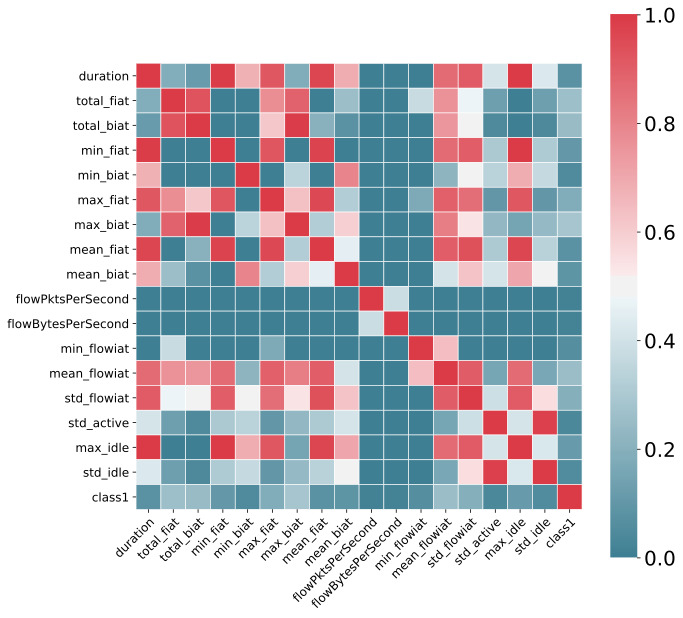

In [86]:
f, ax = plt.subplots(figsize=(10, 10))

#sns.set(font_scale=1.5) - все одновременно
im = sns.heatmap(df_no_corrs.phik_matrix(), mask=np.zeros_like(df_no_corrs.phik_matrix(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, linewidths=.6)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, rotation_mode='anchor', ha='right')

#sns.set_context("poster",font_scale=1.0)

# use matplotlib.colorbar.Colorbar object
cbar = im.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.show()


f.savefig("Hurst/heat_2.jpeg", dpi=400, transparent=True, bbox_inches='tight')

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'max_idle', 'std_idle']


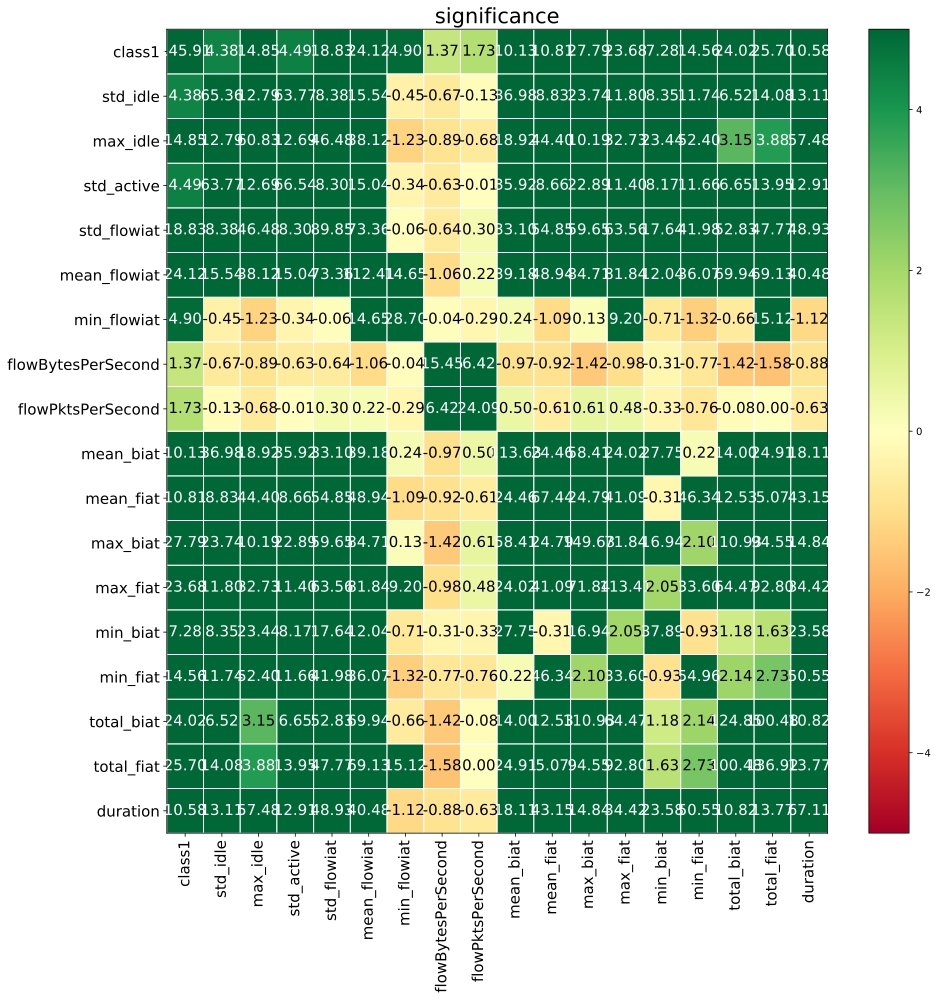

In [87]:
significance_overview = df_no_corrs.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(14,14))
plt.tight_layout()

In [88]:

plt.savefig("Hurst/sign.jpeg", dpi=400, transparent=True, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'max_idle', 'std_idle']


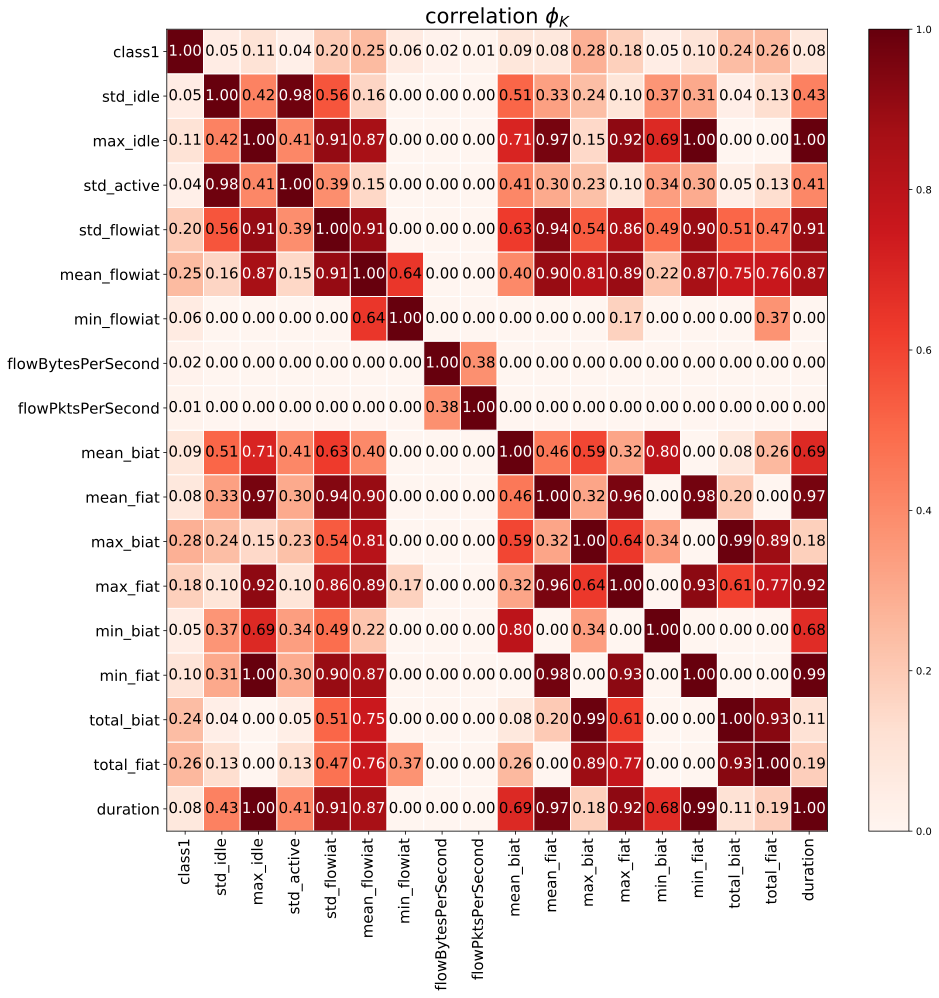

In [89]:
phik_overview = df_no_corrs.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(14,14), print_both_numbers = False)
plt.tight_layout()
plt.savefig("Hurst/nocorrs.jpeg", dpi=400, transparent=True, bbox_inches='tight')



# 30 s

In [90]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-30s-VPN.arff')
df = pd.DataFrame(data[0])

In [91]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [92]:
from sklearn import preprocessing
import numpy as np

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

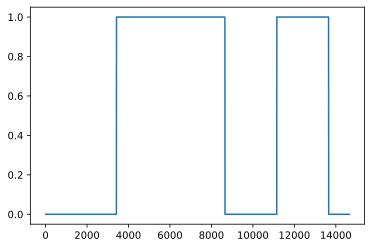

In [93]:
plt.plot(y_bin)

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

## Random Forest

In [95]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8808007279344859


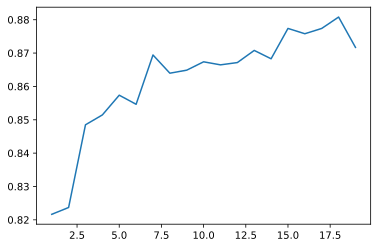

In [96]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

## Hurst

In [97]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [98]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [99]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9645977011494253


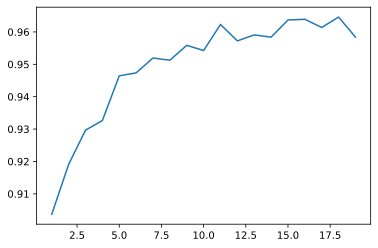

In [100]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# 60 s

In [101]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')
df = pd.DataFrame(data[0])

In [102]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [103]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

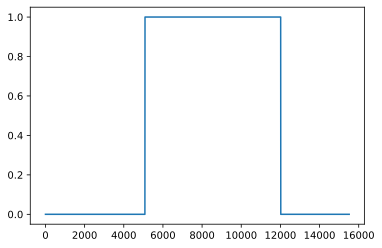

In [104]:
plt.plot(y_bin)

In [105]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

In [106]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8696025778732546


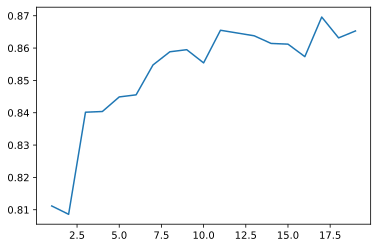

In [107]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

In [108]:
model_quality(X_train, X_test, y_train, y_test, KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

Pr 0.8050081873758336
Rc 0.8013525264846746
F1 0.802737807102859


## Hurst

In [109]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [110]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [111]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.973763440860215


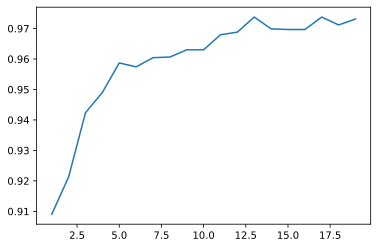

In [112]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# 120 s

In [113]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-120s-VPN.arff')
df = pd.DataFrame(data[0])

In [114]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [115]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

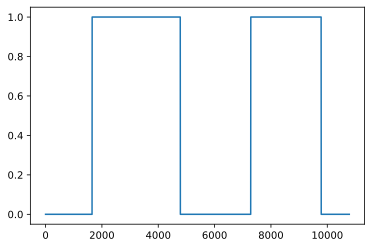

In [116]:
plt.plot(y_bin)

In [117]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

In [118]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8782071097372488


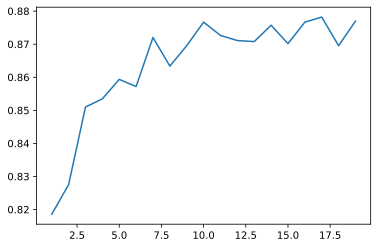

In [119]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

## Hurst

In [120]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [121]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [122]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9666666666666667


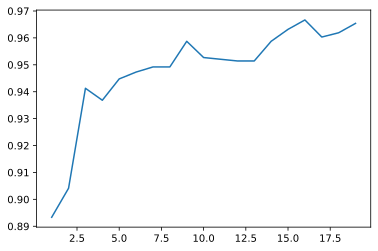

In [123]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# Comparison

In [124]:
x = ["15", "30", "60", "120"]
y_RF = [ 0.895344, 0.8753412, 0.8946, 0.87697]
y_RF_SSR = [ 0.963243243, 0.962988505, 0.967027, 0.963]

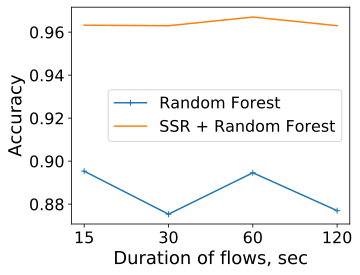

In [125]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
f, ax = plt.subplots(figsize=(5, 4))


ax.plot(x, y_RF, '+', linestyle='solid', label='Random Forest')
ax.plot(x, y_RF_SSR, '--', linestyle='solid', label='SSR + Random Forest')

plt.xlabel('Duration of flows, sec', size = 18);
plt.ylabel('Accuracy', size = 18);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(prop={'size': 16})
f.savefig("Hurst/Accuracy.png", bbox_inches = "tight")

plt.show()